In [133]:
import tensorflow;
import pandas;
from sklearn.model_selection import train_test_split;
from tensorflow import keras;
from tensorflow.keras.models import Sequential;
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt;

## Data Import

In [134]:
# Loading data from pre-cleaned csv file
dataframe = pandas.read_csv("/mnt/e/Code Repository/Campus/Machine Learning/Code/ml-team-project/credit_card_clients.csv");

## Feature Correlation

In this section I set the treshold with 0.2. Any feature below 0.2 will be discarded.

In [135]:
# Correlation Heatmap
correlation = dataframe.corr();

TRESHOLD = 0;
print("Relationship : Correlation Score");

columns_to_be_dropped = [];
for i in correlation.columns:
    correlation_score = correlation[i]["LABEL"];
    print(i, "-> LABEL : ", correlation_score);

    if(correlation_score < TRESHOLD):
        columns_to_be_dropped.append(i);
        print("Dropping ", i);

dataframe = dataframe.drop(columns=columns_to_be_dropped);

Relationship : Correlation Score
ID -> LABEL :  -0.013951954838986251
Dropping  ID
LIMIT_BAL -> LABEL :  -0.1535198763935072
Dropping  LIMIT_BAL
SEX -> LABEL :  -0.03996057770544172
Dropping  SEX
EDUCATION -> LABEL :  0.028006077656250204
MARRIAGE -> LABEL :  -0.024339215683404438
Dropping  MARRIAGE
AGE -> LABEL :  0.013889834301962887
PAY_0 -> LABEL :  0.32479372847862237
PAY_2 -> LABEL :  0.2635512016721678
PAY_3 -> LABEL :  0.23525251372491712
PAY_4 -> LABEL :  0.21661363684242388
PAY_5 -> LABEL :  0.2041489138761645
PAY_6 -> LABEL :  0.18686636165354611
BILL_AMT1 -> LABEL :  -0.019644197143221562
Dropping  BILL_AMT1
BILL_AMT2 -> LABEL :  -0.014193218088215756
Dropping  BILL_AMT2
BILL_AMT3 -> LABEL :  -0.014075518043214726
Dropping  BILL_AMT3
BILL_AMT4 -> LABEL :  -0.010156495880289674
Dropping  BILL_AMT4
BILL_AMT5 -> LABEL :  -0.006760463841014779
Dropping  BILL_AMT5
BILL_AMT6 -> LABEL :  -0.005372314914815558
Dropping  BILL_AMT6
PAY_AMT1 -> LABEL :  -0.07292948777785163
Dropping  

## Data Pre-Processing
Checkout the `main.ipynb` since I just copy-pasting the whole thing from it.

In [136]:
# Some education data contains 0, 5, and 6. I eliminating 'em.

invalid_education_data = [];
for idx, e in enumerate(dataframe['EDUCATION']):
    if(e > 4 or e < 1):
        invalid_education_data.append(idx);

dataframe = dataframe.drop(invalid_education_data);

# Make one hot encoding for Educuation since the data is an ordinal data
hot_encoded_education = pandas.get_dummies(dataframe['EDUCATION'], prefix = "education");

# Merge the hot_encoded with the main dataframe
for i in [hot_encoded_education]:
    dataframe = pandas.concat([dataframe, i], axis = 1);

print("Data after cleaning: ", dataframe.shape);
print(dataframe.columns.tolist());

Data after cleaning:  (29655, 13)
['EDUCATION', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'LABEL', 'education_1', 'education_2', 'education_3', 'education_4']


In [137]:
# Define label data
label = dataframe['LABEL'];

# Drop ID, SEX, EDUCATION, MARRIAGE, and LABEL from dataframe for features
features = dataframe.drop(columns=["EDUCATION", "LABEL"]);

# Typecasting education_1 to 4 to int64 because ANN need to be standardized
dataframe["education_1"] = dataframe["education_1"].astype(int);
dataframe["education_2"] = dataframe["education_2"].astype(int);
dataframe["education_3"] = dataframe["education_3"].astype(int);
dataframe["education_4"] = dataframe["education_4"].astype(int);

# Split the data into training, validation, and testing sets
feature_train, feature_test, label_train, label_test = train_test_split(features, label, test_size = 0.6, random_state = 42);
feature_validation, feature_test, label_validation, label_test = train_test_split(feature_test, label_test, test_size=0.5, random_state = 20);

# Scale the features
scaler = StandardScaler();
feature_train_scaled = scaler.fit_transform(feature_train);
feature_validation_scaled = scaler.fit_transform(feature_validation);
feature_test_scaled = scaler.transform(feature_test);

## Fine Tunning

This code based on Tensorflow Artifical Neural Network.

Epoch 1/15
371/371 [==============================] - 100s 264ms/step - loss: 0.4644 - accuracy: 0.8140 - val_loss: 0.4539 - val_accuracy: 0.8153
Epoch 2/15
371/371 [==============================] - 73s 196ms/step - loss: 0.4442 - accuracy: 0.8203 - val_loss: 0.4467 - val_accuracy: 0.8162
Epoch 3/15
371/371 [==============================] - 21s 57ms/step - loss: 0.4412 - accuracy: 0.8209 - val_loss: 0.4472 - val_accuracy: 0.8152
Epoch 4/15
371/371 [==============================] - 28s 76ms/step - loss: 0.4402 - accuracy: 0.8202 - val_loss: 0.4442 - val_accuracy: 0.8187
Epoch 5/15
371/371 [==============================] - 27s 72ms/step - loss: 0.4379 - accuracy: 0.8237 - val_loss: 0.4450 - val_accuracy: 0.8170
Epoch 6/15
371/371 [==============================] - 27s 73ms/step - loss: 0.4365 - accuracy: 0.8211 - val_loss: 0.4452 - val_accuracy: 0.8191
Epoch 7/15
371/371 [==============================] - 30s 81ms/step - loss: 0.4347 - accuracy: 0.8215 - val_loss: 0.4467 - val_accura

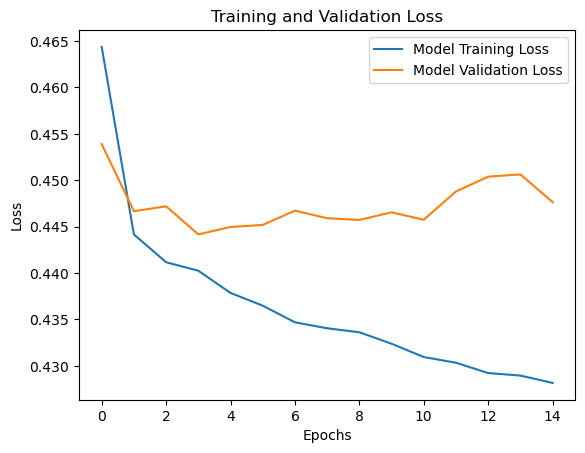

279/279 [==============================] - 8s 29ms/step - loss: 0.4495 - accuracy: 0.8169
Loss:  0.44948816299438477  Accuracy:  0.8169045448303223


In [138]:
class ANNModel:

    optimizer = "adam";

    def input_layer(self):
        return keras.layers.Dense(32, input_dim = 11, activation = "relu"); # 11 is total features dimension

    def hidden_layer(self):
        return [
            keras.layers.Dense(128, activation = "relu"),
            keras.layers.Dense(64, activation = "relu"),
            keras.layers.Dense(32, activation = "relu"),
        ];

    def output_layer(self):
        return keras.layers.Dense(1, activation = "sigmoid"); # Since output is only 1 label.

    def fit(self):
        model = Sequential();
        model.add(self.input_layer());

        for i in self.hidden_layer():
            model.add(i);

        model.add(self.output_layer());

        model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]);

        model_plot = model.fit(feature_train_scaled, label_train, epochs = 15, validation_data=(feature_validation_scaled, label_validation));

        plt.plot(model_plot.history["loss"], label = "Model Training Loss");
        plt.plot(model_plot.history["val_loss"], label = "Model Validation Loss");
        plt.title("Training and Validation Loss");
        plt.xlabel("Epochs");
        plt.ylabel("Loss");
        plt.legend();
        plt.show();

        return model;

dojo = ANNModel();
model = dojo.fit();

loss, accuracy = model.evaluate(feature_test_scaled, label_test);
print("Loss: ", loss, " Accuracy: ", accuracy);